# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


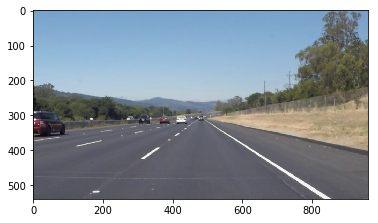

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
listPictures = os.listdir("test_images/")
print(listPictures)
type(listPictures[0])
dotNumber = listPictures[1].find(".")
print(dotNumber)
oldName = listPictures[1]
newName = oldName[0:dotNumber] + "Out"+oldName[dotNumber:]
print(newName)

['solidWhiteCurve.jpg', 'solidWhiteCurveOut.jpg', 'solidWhiteRight.jpg', 'solidWhiteRightOut.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowCurve2Out.jpg', 'solidYellowCurveOut.jpg', 'solidYellowLeft.jpg', 'solidYellowLeftOut.jpg', 'whiteCarLaneSwitch.jpg', 'whiteCarLaneSwitchOut.jpg']
18
solidWhiteCurveOutOut.jpg


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

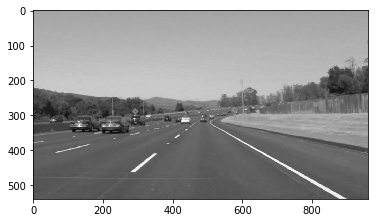

[[[745 454 897 538]]

 [[524 335 650 407]]

 [[760 470 863 531]]

 [[563 353 596 372]]

 [[677 423 745 461]]

 [[292 462 353 411]]

 [[305 441 346 410]]

 [[646 399 748 455]]

 [[854 525 877 538]]

 [[452 335 456 332]]

 [[411 365 414 363]]

 [[295 461 317 442]]

 [[679 423 700 435]]

 [[280 460 307 440]]

 [[599 373 649 401]]

 [[652 408 669 418]]

 [[742 460 808 499]]

 [[513 326 561 352]]

 [[449 332 461 322]]

 [[863 519 869 522]]

 [[293 450 294 449]]

 [[308 439 312 436]]

 [[457 330 469 322]]

 [[845 509 851 512]]

 [[508 326 530 339]]

 [[550 349 559 354]]

 [[408 366 411 364]]

 [[800 484 804 486]]]


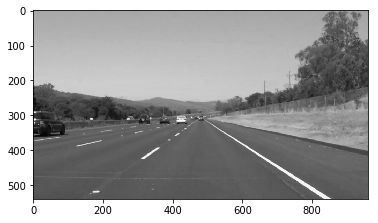

[[[524 333 853 539]]

 [[609 392 747 482]]

 [[552 350 653 413]]

 [[485 311 530 340]]

 [[720 465 832 538]]

 [[527 339 605 388]]

 [[319 425 362 394]]

 [[387 370 389 369]]

 [[445 330 464 316]]

 [[310 423 356 392]]

 [[783 494 801 505]]

 [[800 505 853 538]]

 [[410 359 419 353]]

 [[454 327 467 318]]

 [[433 339 438 336]]

 [[580 373 626 402]]

 [[360 396 363 394]]

 [[785 508 832 539]]

 [[452 324 459 319]]

 [[321 415 334 406]]

 [[507 322 533 338]]

 [[187 521 189 520]]

 [[331 417 332 416]]

 [[447 332 449 330]]]


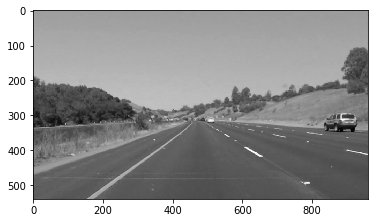

[[[154 538 340 408]]

 [[175 538 279 460]]

 [[347 411 369 394]]

 [[330 416 433 341]]

 [[286 456 359 401]]

 [[613 391 652 414]]

 [[606 392 632 409]]

 [[372 392 417 357]]

 [[548 356 558 362]]

 [[489 322 515 335]]

 [[288 445 291 443]]

 [[370 388 389 374]]

 [[420 356 456 326]]

 [[625 404 648 419]]

 [[527 339 533 342]]

 [[437 338 439 336]]

 [[513 332 516 334]]

 [[552 354 563 361]]

 [[525 339 532 343]]

 [[280 460 294 449]]

 [[495 321 507 328]]

 [[399 372 419 356]]

 [[363 393 367 390]]

 [[576 372 579 374]]

 [[487 316 490 318]]

 [[640 413 650 419]]

 [[233 482 247 472]]

 [[366 396 367 395]]

 [[164 532 171 527]]]


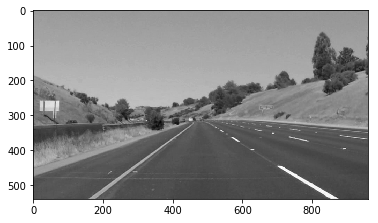

[[[274 465 413 360]]

 [[364 391 457 324]]

 [[212 513 288 455]]

 [[159 538 297 438]]

 [[804 498 863 532]]

 [[721 459 804 510]]

 [[332 414 368 387]]

 [[785 498 829 525]]

 [[723 452 780 484]]

 [[509 328 513 330]]

 [[568 365 585 375]]

 [[569 365 588 376]]

 [[573 363 591 373]]

 [[428 350 438 342]]

 [[539 342 545 346]]

 [[807 511 836 529]]

 [[759 473 798 494]]

 [[700 446 754 480]]

 [[369 387 388 373]]

 [[187 533 201 521]]

 [[412 362 427 350]]

 [[286 447 322 420]]

 [[230 500 231 499]]

 [[432 346 460 325]]

 [[800 495 810 501]]

 [[454 331 456 329]]

 [[194 528 218 509]]

 [[355 403 361 398]]

 [[353 399 362 392]]

 [[712 445 737 459]]

 [[494 321 500 324]]

 [[345 405 346 404]]

 [[221 494 225 491]]

 [[363 397 373 389]]

 [[846 535 852 538]]

 [[261 465 280 451]]

 [[497 322 512 330]]

 [[538 342 543 345]]]


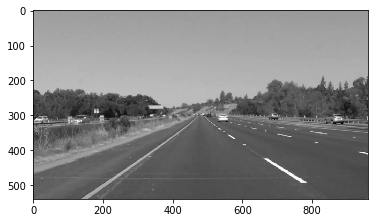

[[[430 341 450 327]]

 [[138 539 333 407]]

 [[207 504 367 388]]

 [[661 425 722 464]]

 [[677 428 692 437]]

 [[138 538 163 521]]

 [[561 355 579 366]]

 [[223 481 224 480]]

 [[217 485 220 483]]

 [[376 377 440 329]]

 [[715 459 768 493]]

 [[730 459 765 480]]

 [[314 419 352 394]]

 [[345 405 429 342]]

 [[672 424 732 460]]

 [[158 538 194 512]]

 [[245 466 313 420]]

 [[169 531 181 522]]

 [[362 386 379 374]]

 [[558 358 574 368]]

 [[417 352 435 338]]

 [[772 485 780 490]]

 [[414 354 415 353]]

 [[340 401 365 385]]

 [[565 358 578 366]]

 [[509 323 520 330]]]


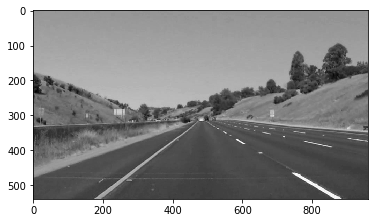

[[[195 538 319 441]]

 [[185 532 367 395]]

 [[816 500 874 532]]

 [[443 345 463 329]]

 [[782 491 794 498]]

 [[849 530 863 538]]

 [[818 502 820 503]]

 [[743 467 863 539]]

 [[769 474 785 483]]

 [[392 383 449 341]]

 [[767 472 804 493]]

 [[288 465 394 382]]

 [[654 406 657 408]]

 [[401 372 459 328]]

 [[493 315 495 316]]

 [[505 326 520 334]]

 [[521 331 522 332]]

 [[754 465 762 469]]

 [[584 368 607 381]]

 [[581 371 603 383]]

 [[453 332 455 330]]

 [[457 329 469 319]]

 [[545 348 552 352]]

 [[266 472 267 471]]

 [[307 441 308 440]]

 [[477 313 478 312]]

 [[496 319 503 323]]

 [[378 389 410 364]]

 [[527 338 531 340]]

 [[366 397 387 381]]

 [[563 358 567 360]]

 [[788 485 799 491]]

 [[501 319 512 326]]

 [[551 349 555 352]]

 [[176 538 205 516]]

 [[832 510 870 531]]

 [[355 405 356 404]]

 [[315 435 316 434]]

 [[250 484 251 483]]

 [[506 323 520 331]]

 [[221 519 246 499]]

 [[501 323 508 327]]

 [[291 453 292 452]]

 [[323 429 340 416]]

 [[794 497 846 528]]]


In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
from scipy import optimize
listPictures = ['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 
                'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
for imageName1 in listPictures:
    ################################################
    #1. 图像的导入与图像的灰度化
    imageName = "test_images/" + imageName1
    image = cv2.imread(imageName)
    plt.figure(num = 'ceshi')
    plt.imshow(image)
    originImage = np.copy(image)
    # plt.imshow(image)
    # plt.figure()
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # 图像灰度化
    plt.imshow(gray,cmap = 'gray')
    plt.show()

    ###################################################
    #2. Define a kernel size for gaussian smoothing / blurring
        # Note: this step is optional as cv2.Canny() applies a 5*5 Gaussian internally
    kernalSize = 5
    blurGray = cv2.GaussianBlur(gray,(kernalSize,kernalSize),0)

    ##############################################
    #3. 图像的边缘检测，使用canny算子进行边缘检测
        # Define parameters for Canny and run it
    lowThreshold = 70
    highThreshold = 150
    edges = cv2.Canny(blurGray,lowThreshold,highThreshold) # 边缘检测
    # Display the image of canny
    # plt.imshow(edges,cmap='Greys_r')

    #############################################
    #4. Defining a four sided polygon to mask
    # Creat a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges) # 返回一个全部为0的矩阵，大小和edges 相等
    ignoreMaskColor = 255
    imShape = image.shape
    # 定义一个用于框选兴趣区域的四边形的角点，
    vetices = np.array([[(60,imShape[0]),(475,310),(imShape[1]-475,310),(imShape[1]-60,imShape[0])]],dtype = np.int32)
    cv2.fillPoly(mask,vetices,ignoreMaskColor)
    maskedEdges = cv2.bitwise_and(edges,mask); # 筛选出兴趣区域
    #plt.figure(num = 'masd444k')
    #plt.imshow(mask)
    #plt.figure(num = 'masdk')
    #plt.imshow(maskedEdges)
   
    ##################################################
    #5.Define the Hough transform parameters
    rho = 1 # distance resolution in radians of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30 # minimum number of votes(intersections in Hough grid cell)
    minLineLenght = 1 # minimum number of pixels makeing up a line
    maxLineGap = 1 # maximum gap in pixels between connectable line segments
    lineImage = np.copy(image) * 0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(maskedEdges,rho,theta,threshold,np.array([]),minLineLenght,maxLineGap)
    print(lines)
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(lineImage,(x1,y1),(x2,y2),(0,0,255),6)
    # Creat a "color" binary image to combine with line image
    colorEdges = np.dstack((edges,edges,edges))
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image,0.8,lineImage,1,0)
    # cv2.imshow('combo',combo)
    #plt.imshow(image)
    dotNumber = imageName1.find(".")
    # print(dotNumber)
    oldName = imageName1
    newName = oldName[0:dotNumber] + "Out"+oldName[dotNumber:]
    newDirName = "test_images/" + newName
    cv2.imwrite(newDirName,combo)

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # 图像灰度化

    ###################################################
    #2. Define a kernel size for gaussian smoothing / blurring
        # Note: this step is optional as cv2.Canny() applies a 5*5 Gaussian internally
    kernalSize = 5
    blurGray = cv2.GaussianBlur(gray,(kernalSize,kernalSize),0)

    ##############################################
    #3. 图像的边缘检测，使用canny算子进行边缘检测
        # Define parameters for Canny and run it
    lowThreshold = 70
    highThreshold = 150
    edges = cv2.Canny(blurGray,lowThreshold,highThreshold) # 边缘检测

    #############################################
    #4. Defining a four sided polygon to mask
    # Creat a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges) # 返回一个全部为0的矩阵，大小和edges 相等
    ignoreMaskColor = 255
    imShape = image.shape
    # 定义一个用于框选兴趣区域的四边形的角点，
    vetices = np.array([[(60,imShape[0]),(475,310),(imShape[1]-475,310),(imShape[1]-60,imShape[0])]],dtype = np.int32)
    # vetices = np.array([[(100,imShape[0]-70),(600,460),(imShape[1]-600,460),(imShape[1]-100,imShape[0]-70)]],dtype = np.int32)
    cv2.fillPoly(mask,vetices,ignoreMaskColor)
    maskedEdges = cv2.bitwise_and(edges,mask); # 筛选出兴趣区域

    ##################################################
    #5.Define the Hough transform parameters
    rho = 1 # distance resolution in radians of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30 # minimum number of votes(intersections in Hough grid cell)
    minLineLenght = 1 # minimum number of pixels makeing up a line
    maxLineGap = 1 # maximum gap in pixels between connectable line segments
    lineImage = np.copy(image) * 0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(maskedEdges,rho,theta,threshold,np.array([]),minLineLenght,maxLineGap)
    # print(lines)
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(lineImage,(x1,y1),(x2,y2),(255,0,0),6)
    # Creat a "color" binary image to combine with line image
    colorEdges = np.dstack((edges,edges,edges))
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image,0.8,lineImage,1,0)
    return combo

Let's try the one with the solid white lane on the right first ...

In [8]:
Aold1 = 0
Bold1 = 0
Aold2 = 0
Bold2 = 0


def process_image_improment(image):
    global Aold1 
    global Bold1 
    global Aold2 
    global Bold2 
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # 图像灰度化

    ###################################################
    #2. Define a kernel size for gaussian smoothing / blurring
        # Note: this step is optional as cv2.Canny() applies a 5*5 Gaussian internally
    kernalSize = 5
    blurGray = cv2.GaussianBlur(gray,(kernalSize,kernalSize),0)

    ##############################################
    #3. 图像的边缘检测，使用canny算子进行边缘检测
        # Define parameters for Canny and run it
    lowThreshold = 70
    highThreshold = 150
    edges = cv2.Canny(blurGray,lowThreshold,highThreshold) # 边缘检测

    #############################################
    #4. Defining a four sided polygon to mask
    # Creat a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges) # 返回一个全部为0的矩阵，大小和edges 相等
    ignoreMaskColor = 255
    imShape = image.shape
    # 定义一个用于框选兴趣区域的四边形的角点，
    vetices = np.array([[(60,imShape[0]),(475,310),(imShape[1]-475,310),(imShape[1]-50,imShape[0])]],dtype = np.int32)
    # vetices = np.array([[(100,imShape[0]-70),(600,460),(imShape[1]-600,460),(imShape[1]-100,imShape[0]-70)]],dtype = np.int32)
    cv2.fillPoly(mask,vetices,ignoreMaskColor)
    maskedEdges = cv2.bitwise_and(edges,mask); # 筛选出兴趣区域
    
    ##################################################
    #5.Define the Hough transform parameters
    rho = 1 # distance resolution in radians of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30 # minimum number of votes(intersections in Hough grid cell)
    minLineLenght = 1 # minimum number of pixels makeing up a line
    maxLineGap = 1 # maximum gap in pixels between connectable line segments
    lineImage = np.copy(image) * 0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(maskedEdges,rho,theta,threshold,np.array([]),minLineLenght,maxLineGap)
    lines = lines.reshape(lines.shape[0],4)
    # print((lines))
    #newlines = np.zeros([lines.shape[0],1,5])
    positiveSlopeLine = np.copy(lines)
    negativeSlopeLine = np.copy(lines)
    i = 0
    j = 0
    for line in lines: # append new column
        slopeLess0 = (line[2]-line[0])/ (line[3]-line[1])
        if slopeLess0 < -1 and slopeLess0 >-2:
            i =i+1
        else:   
            positiveSlopeLine =  np.delete(positiveSlopeLine,i,0)#axis = 0
    for line in lines: # append new column # Control the right line
        slopeLess0 = (line[2]-line[0])/ (line[3]-line[1])
        if slopeLess0 > 1 and slopeLess0 <2:
            j = j+1
        else:            
            negativeSlopeLine = np.delete(negativeSlopeLine,j,0)#axis = 0
    positivePoints = np.zeros((positiveSlopeLine.shape[0]*2,2))
    negativePoints = np.zeros((negativeSlopeLine.shape[0]*2,2))
    k = 0
    for point in positiveSlopeLine:
        positivePoints[k] = [point[0],point[1]]
        #k = k+1
        positivePoints[k+1] = [point[2],point[3]]
        k = k+2
    positiveLineParameters = np.array([0])
    x0 = positivePoints[:,0]
    y0 = positivePoints[:,1]
    #直线方程函数  
    def f_1(x, A, B):  
        return A*x + B 
    A1,B1 = optimize.curve_fit(f_1,x0,y0)[0]
    A1 = A1*0.3+Aold1*0.7
    B1 = B1*0.3+Bold1*0.7
    A1 =  np.clip(A1,-1.8,1.8)
    y1 = np.array([imShape[0],330])
    x1 = (y1-B1)/A1
    cv2.line(lineImage,(int(x1[0]),int(y1[0])),(int(x1[1]),int(y1[1])),(0,0,255),6)
    k = 0
    for point in negativeSlopeLine:
        negativePoints[k] = [point[0],point[1]]
        #k = k+1
        negativePoints[k+1] = [point[2],point[3]]
        k = k+2
    negativeLineParameters = np.array([0])
    x0 = negativePoints[:,0]
    y0 = negativePoints[:,1]
    A2,B2 = optimize.curve_fit(f_1,x0,y0)[0]
    A2 = A2*0.3+Aold2*0.7
    A2 = np.clip(A2,0.5,0.8)
    B2 = B2*0.3+Bold2*0.7
    y1 = np.array([imShape[0],330])
    x1 = (y1-B2)/A2
    cv2.line(lineImage,(int(x1[0]),int(y1[0])),(int(x1[1]),int(y1[1])),(0,0,255),6)
    colorEdges = np.dstack((edges,edges,edges))
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image,0.8,lineImage,1,0)
    # filter
    Aold1 = A1
    Bold1 = B1
    Aold2 = A2
    Bold2 = B2
    return combo

In [9]:
# aa = process_image(image)
# plt.imshow(process_image(image))

In [10]:
Aold1 = 0
Bold1 = 0
Aold2 = 0
Bold2 = 0


def process_image_challenge(image):
    global Aold1 
    global Bold1 
    global Aold2 
    global Bold2 
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # 图像灰度化
    
    ###################################################
    #2. Define a kernel size for gaussian smoothing / blurring
        # Note: this step is optional as cv2.Canny() applies a 5*5 Gaussian internally
    kernalSize = 5
    blurGray = cv2.GaussianBlur(gray,(kernalSize,kernalSize),0)

    ##############################################
    #3. 图像的边缘检测，使用canny算子进行边缘检测
        # Define parameters for Canny and run it
    lowThreshold = 70
    highThreshold = 150
    edges = cv2.Canny(blurGray,lowThreshold,highThreshold) # 边缘检测

    #############################################
    #4. Defining a four sided polygon to mask
    # Creat a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges) # 返回一个全部为0的矩阵，大小和edges 相等
    ignoreMaskColor = 255
    imShape = image.shape
    # 定义一个用于框选兴趣区域的四边形的角点，
    vetices = np.array([[(100,imShape[0]-50),(450,310),(imShape[1]-450,310),(imShape[1]-100,imShape[0]-50)]],dtype = np.int32)
    # vetices = np.array([[(100,imShape[0]-70),(600,460),(imShape[1]-600,460),(imShape[1]-100,imShape[0]-70)]],dtype = np.int32)
    cv2.fillPoly(mask,vetices,ignoreMaskColor)
    maskedEdges = cv2.bitwise_and(edges,mask); # 筛选出兴趣区域

    ##################################################
    #5.Define the Hough transform parameters
    rho = 1 # distance resolution in radians of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30 # minimum number of votes(intersections in Hough grid cell)
    minLineLenght = 1 # minimum number of pixels makeing up a line
    maxLineGap = 1 # maximum gap in pixels between connectable line segments
    lineImage = np.copy(image) * 0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(maskedEdges,rho,theta,threshold,np.array([]),minLineLenght,maxLineGap)
    lines = lines.reshape(lines.shape[0],4)
    positiveSlopeLine = np.copy(lines)
    negativeSlopeLine = np.copy(lines)
    i = 0
    j = 0
    for line in lines: # append new column
        slopeLess0 = (line[2]-line[0])/ (line[3]-line[1])
        if slopeLess0 < -1 and slopeLess0 >-2:
            i =i+1
        else:   
            positiveSlopeLine =  np.delete(positiveSlopeLine,i,0)#axis = 0
    for line in lines: # append new column # Control the right line
        slopeLess0 = (line[2]-line[0])/ (line[3]-line[1])
        if slopeLess0 > 1 and slopeLess0 <2:
            j = j+1
        else:            
            negativeSlopeLine = np.delete(negativeSlopeLine,j,0)#axis = 0
    positivePoints = np.zeros((positiveSlopeLine.shape[0]*2,2))
    negativePoints = np.zeros((negativeSlopeLine.shape[0]*2,2))
    k = 0
    for point in positiveSlopeLine:
        positivePoints[k] = [point[0],point[1]]
        #k = k+1
        positivePoints[k+1] = [point[2],point[3]]
        k = k+2
    positiveLineParameters = np.array([0])
    x0 = positivePoints[:,0]
    y0 = positivePoints[:,1]
    #直线方程函数  
    def f_1(x, A, B):  
        return A*x + B 
    A1,B1 = optimize.curve_fit(f_1,x0,y0)[0]
    A1 = A1*0.3+Aold1*0.7
    B1 = B1*0.3+Bold1*0.7
    A1 =  np.clip(A1,-1.8,1.8)
    y1 = np.array([imShape[0],430])
    x1 = (y1-B1)/A1
    cv2.line(lineImage,(int(x1[0]),int(y1[0])),(int(x1[1]),int(y1[1])),(0,0,255),6)
    k = 0
    for point in negativeSlopeLine:
        negativePoints[k] = [point[0],point[1]]
        #k = k+1
        negativePoints[k+1] = [point[2],point[3]]
        k = k+2
    negativeLineParameters = np.array([0])
    x0 = negativePoints[:,0]
    y0 = negativePoints[:,1]
    A2,B2 = optimize.curve_fit(f_1,x0,y0)[0]
    A2 = A2*0.3+Aold2*0.7
    A2 = np.clip(A2,0.5,0.8)
    B2 = B2*0.3+Bold2*0.7
    y1 = np.array([imShape[0],430])
    x1 = (y1-B2)/A2
    cv2.line(lineImage,(int(x1[0]),int(y1[0])),(int(x1[1]),int(y1[1])),(0,0,255),6)
    colorEdges = np.dstack((edges,edges,edges))
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image,0.8,lineImage,1,0)
    # filter
    Aold1 = A1
    Bold1 = B1
    Aold2 = A2
    Bold2 = B2
    return combo

In [11]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'test_videos_output/solidYellowLeftImproment.mp4' # solidWhiteRightImproment
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4') # solidWhiteRight
yellow_clip = clip2.fl_image(process_image_improment)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge) # process_image_challenge
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:26<00:00,  9.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 29.7 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))